Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [10]:
from random import random
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from icecream import ic
from itertools import accumulate
import heapq

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [11]:
UNIVERSE_SIZE = 100_000
NUM_SETS = 10_000
DENSITY = 0.3

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [12]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)


## Helper Functions

In [13]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [14]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution), cost(solution)

(np.True_, np.float64(841113629.1147779))

In [15]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution), cost(solution)

(np.True_, np.float64(423468112.3324337))

In [16]:

def tweak(solution: np.ndarray) -> np.ndarray:
    """Modifica una soluzione esistente cambiando casualmente uno dei set (flip)"""
    new_solution = solution.copy() 
    index = None
    while index is None or np.random.random() < 0.5:
        index = np.random.randint(0, len(solution))
        new_solution[index] = not new_solution[index]     
    return new_solution





def fitness(solution):
    """Valuta la qualità della soluzione in base alla validità e al costo"""
    is_valid = valid(solution)  # Controlla la validità della copertura
    return (is_valid, -cost(solution))   # Minimizza il costo se valido

def greedy_initialization():
    """Genera una soluzione valida usando un approccio greedy"""
    universe_covered = np.zeros(SETS.shape[1], dtype=bool)
    solution = np.zeros(len(SETS), dtype=bool)
    
    while not np.all(universe_covered):
        best_set = -1
        best_ratio = float('inf')
        for i in range(len(SETS)):
            if solution[i]:  # Ignora i set già selezionati
                continue
            new_coverage = np.logical_and(SETS[i], np.logical_not(universe_covered)).sum()
            if new_coverage > 0:
                cost_per_coverage = COSTS[i] / new_coverage
                if cost_per_coverage < best_ratio:
                    best_ratio = cost_per_coverage
                    best_set = i
        
        if best_set == -1:
            break
        
        solution[best_set] = True
        universe_covered = np.logical_or(universe_covered, SETS[best_set])
    return solution


def random_initialization():
    """Genera una soluzione casuale valida."""
    solution = np.zeros(NUM_SETS, dtype=bool)
    universe_covered = np.zeros(SETS.shape[1], dtype=bool)

    while not np.all(universe_covered):
        # Seleziona un set casuale
        random_index = np.random.randint(0, NUM_SETS)
        solution[random_index] = True  # Aggiungi il set
        universe_covered = np.logical_or(universe_covered, SETS[random_index])  # Aggiorna la copertura

    return solution

Soluzione valida: True
Fitness della miglior soluzione trovata: -1680480.8035962293


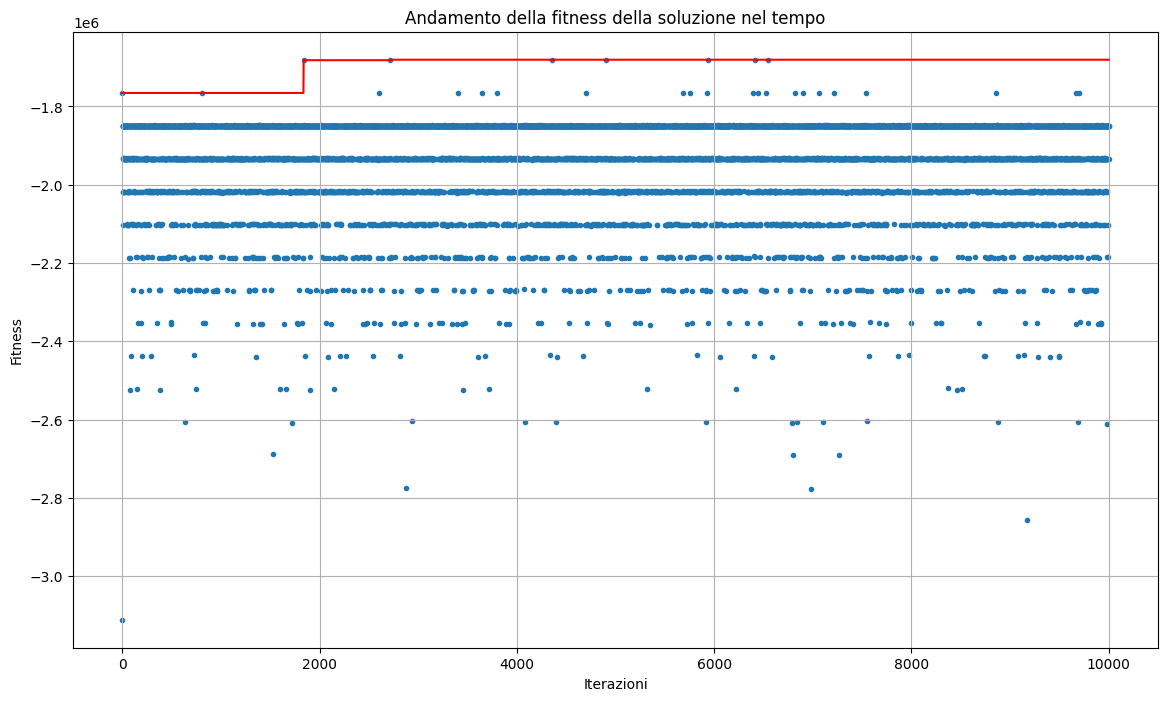

In [17]:

#uso un approccio greedy per inizializzare 

def local_search(max_iters=10000):
    """Esegue una ricerca locale per trovare una soluzione valida"""
    current_solution = greedy_initialization()  # Inizializzazione con una soluzione valida
   
    current_fitness = fitness(current_solution)

    best_solution = current_solution.copy()
    best_fitness = current_fitness
    
    fitness_history = [best_fitness[1]]  # Storico delle fitness

    for iteration in range(max_iters):
        # Genera una nuova soluzione vicina usando la funzione tweak
        
        new_solution = tweak(current_solution)
        new_fitness = fitness(new_solution)
        
        fitness_history.append(new_fitness[1])  # Aggiungi la fitness attuale alla lista

        # Se la nuova soluzione è migliore, aggiorna
        if new_fitness[0] and new_fitness[1] > best_fitness[1]:
            current_solution = new_solution
            current_fitness = new_fitness
            best_solution = new_solution.copy()
            best_fitness = new_fitness

    return best_solution, best_fitness[1], fitness_history

# Esegui la ricerca locale
best_solution, best_fitness_value, fitness_history = local_search()

# Risultati
print("Soluzione valida:", valid(best_solution))
print("Fitness della miglior soluzione trovata:", np.max(fitness_history))

# Plot della fitness nel tempo
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(fitness_history)),
    list(accumulate(fitness_history, max)),  # Accumula le fitness
    color="red",
)
_ = plt.scatter(range(len(fitness_history)), fitness_history, marker=".")
plt.title("Andamento della fitness della soluzione nel tempo")
plt.xlabel("Iterazioni")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()



Soluzione valida: True
Fitness della miglior soluzione trovata: -1680181.3470982546


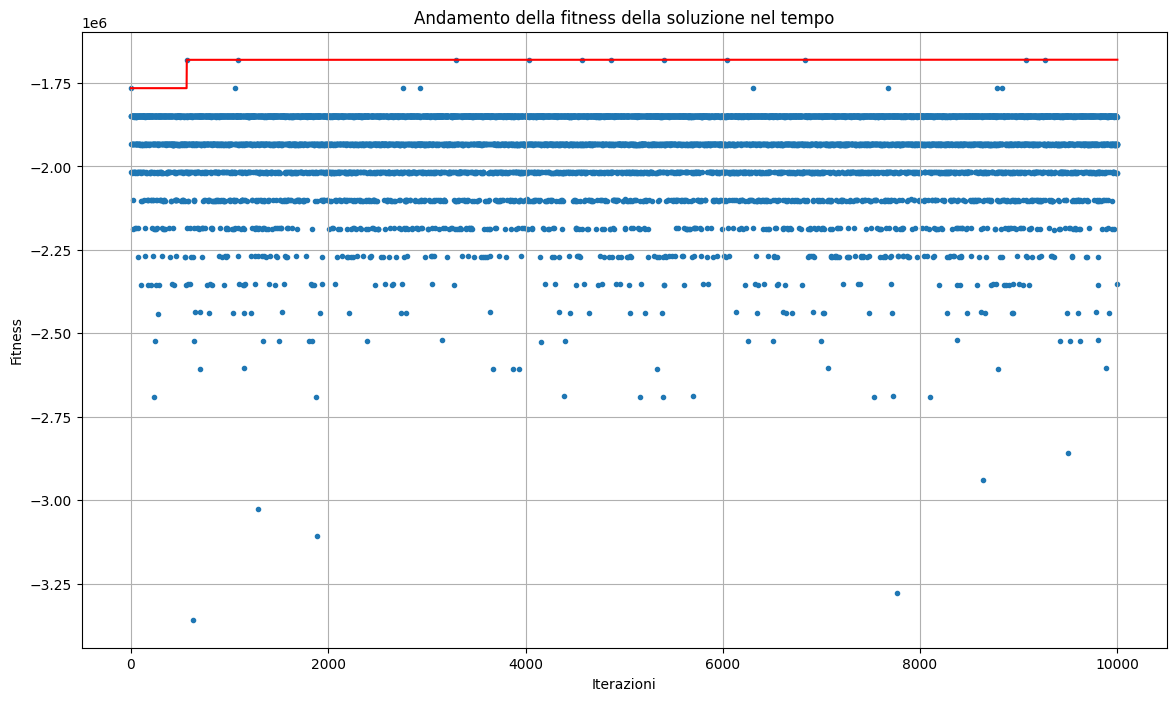

In [18]:

def simulated_annealing_tabu(max_iters=10000, start_temp=3000, cooling_rate=0.95, tabu_tenure=100):
    """Esegue un algoritmo combinato di Simulated Annealing e Tabu Search"""
    current_solution = greedy_initialization()  # Inizializzazione con una soluzione valida
    
   # current_solution = solution = np.full(NUM_SETS, True)
    current_fitness = fitness(current_solution)

    best_solution = current_solution.copy()
    best_fitness = current_fitness
    temp = start_temp
    
    # Set Tabu
    tabu_set = set()
    
    fitness_history = [best_fitness[1]]  # Storico delle fitness

    for iteration in range(max_iters):
        # Genera una nuova soluzione vicina usando la funzione tweak
        new_solution = tweak(current_solution)
        new_fitness = fitness(new_solution)
        fitness_history.append(new_fitness[1])  # Aggiungi la fitness attuale alla lista

        # Se la nuova soluzione è valida e non è nel tabu set
        if new_fitness[0] and tuple(new_solution) not in tabu_set:
            # Calcola il delta di costo
            delta_cost = new_fitness[1] - current_fitness[1]

            # Simulated Annealing acceptance criteria
            if delta_cost > 0 or random() < np.exp(delta_cost / temp):
                current_solution = new_solution
                current_fitness = new_fitness

                # Aggiorna la migliore soluzione trovata
                if current_fitness[1] > best_fitness[1]:
                    best_solution = current_solution.copy()
                    best_fitness = current_fitness
            
            # Aggiungi la soluzione corrente al tabu set
            tabu_set.add(tuple(current_solution))
            if len(tabu_set) > tabu_tenure:
                tabu_set.pop()  # Rimuovi la soluzione più vecchia

        # Aggiorna la temperatura
        temp *= cooling_rate
       
    return best_solution, best_fitness[1], fitness_history

# Esegui l'algoritmo combinato
best_solution, best_fitness_value, fitness_history = simulated_annealing_tabu()

# Risultati
print("Soluzione valida:", valid(best_solution))
print("Fitness della miglior soluzione trovata:", np.max(fitness_history))

# Plot della fitness nel tempo
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(fitness_history)),
    list(accumulate(fitness_history, max)),  # Accumula le fitness
    color="red",
)
_ = plt.scatter(range(len(fitness_history)), fitness_history, marker=".")
plt.title("Andamento della fitness della soluzione nel tempo")
plt.xlabel("Iterazioni")
plt.ylabel("Fitness")
plt.grid(True)
plt.show()